# Import needed modules

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import zipfile

# zip_file_path = 'drive/MyDrive/dataset.zip'
# destination_path = 'drive/MyDrive/'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(destination_path)

# print(f"'{zip_file_path}' has been extracted to '{destination_path}'")


#### **Function to create data frame**

In [6]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(train_dir, test_dir):
    # train and valid dataframe
    files, classes = define_paths(train_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # test dataframe
    files, classes = define_paths(test_dir)
    test_df = define_df(files, classes)

    return train_df, valid_df, test_df

#### Function to generate images from dataframe

In [20]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(rescale=1./255, horizontal_flip= True)
    ts_gen = ImageDataGenerator(rescale=1./255)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [22]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i]      # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Callbacks**
<br>
Callbacks : Helpful functions to help optimize model training  <br>
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [23]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

#### **Function to plot history of training**

In [24]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


#### **Function to create Confusion Matrix**

In [25]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# **Model Structure**

#### **Start Reading Dataset**

#### **Display Image Sample**

In [26]:
train_dir = 'drive/MyDrive/dataset/train'
test_dir = 'drive/MyDrive/dataset/test'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(train_dir, test_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 2395 validated image filenames belonging to 2 classes.
Found 599 validated image filenames belonging to 2 classes.
Found 68 validated image filenames belonging to 2 classes.


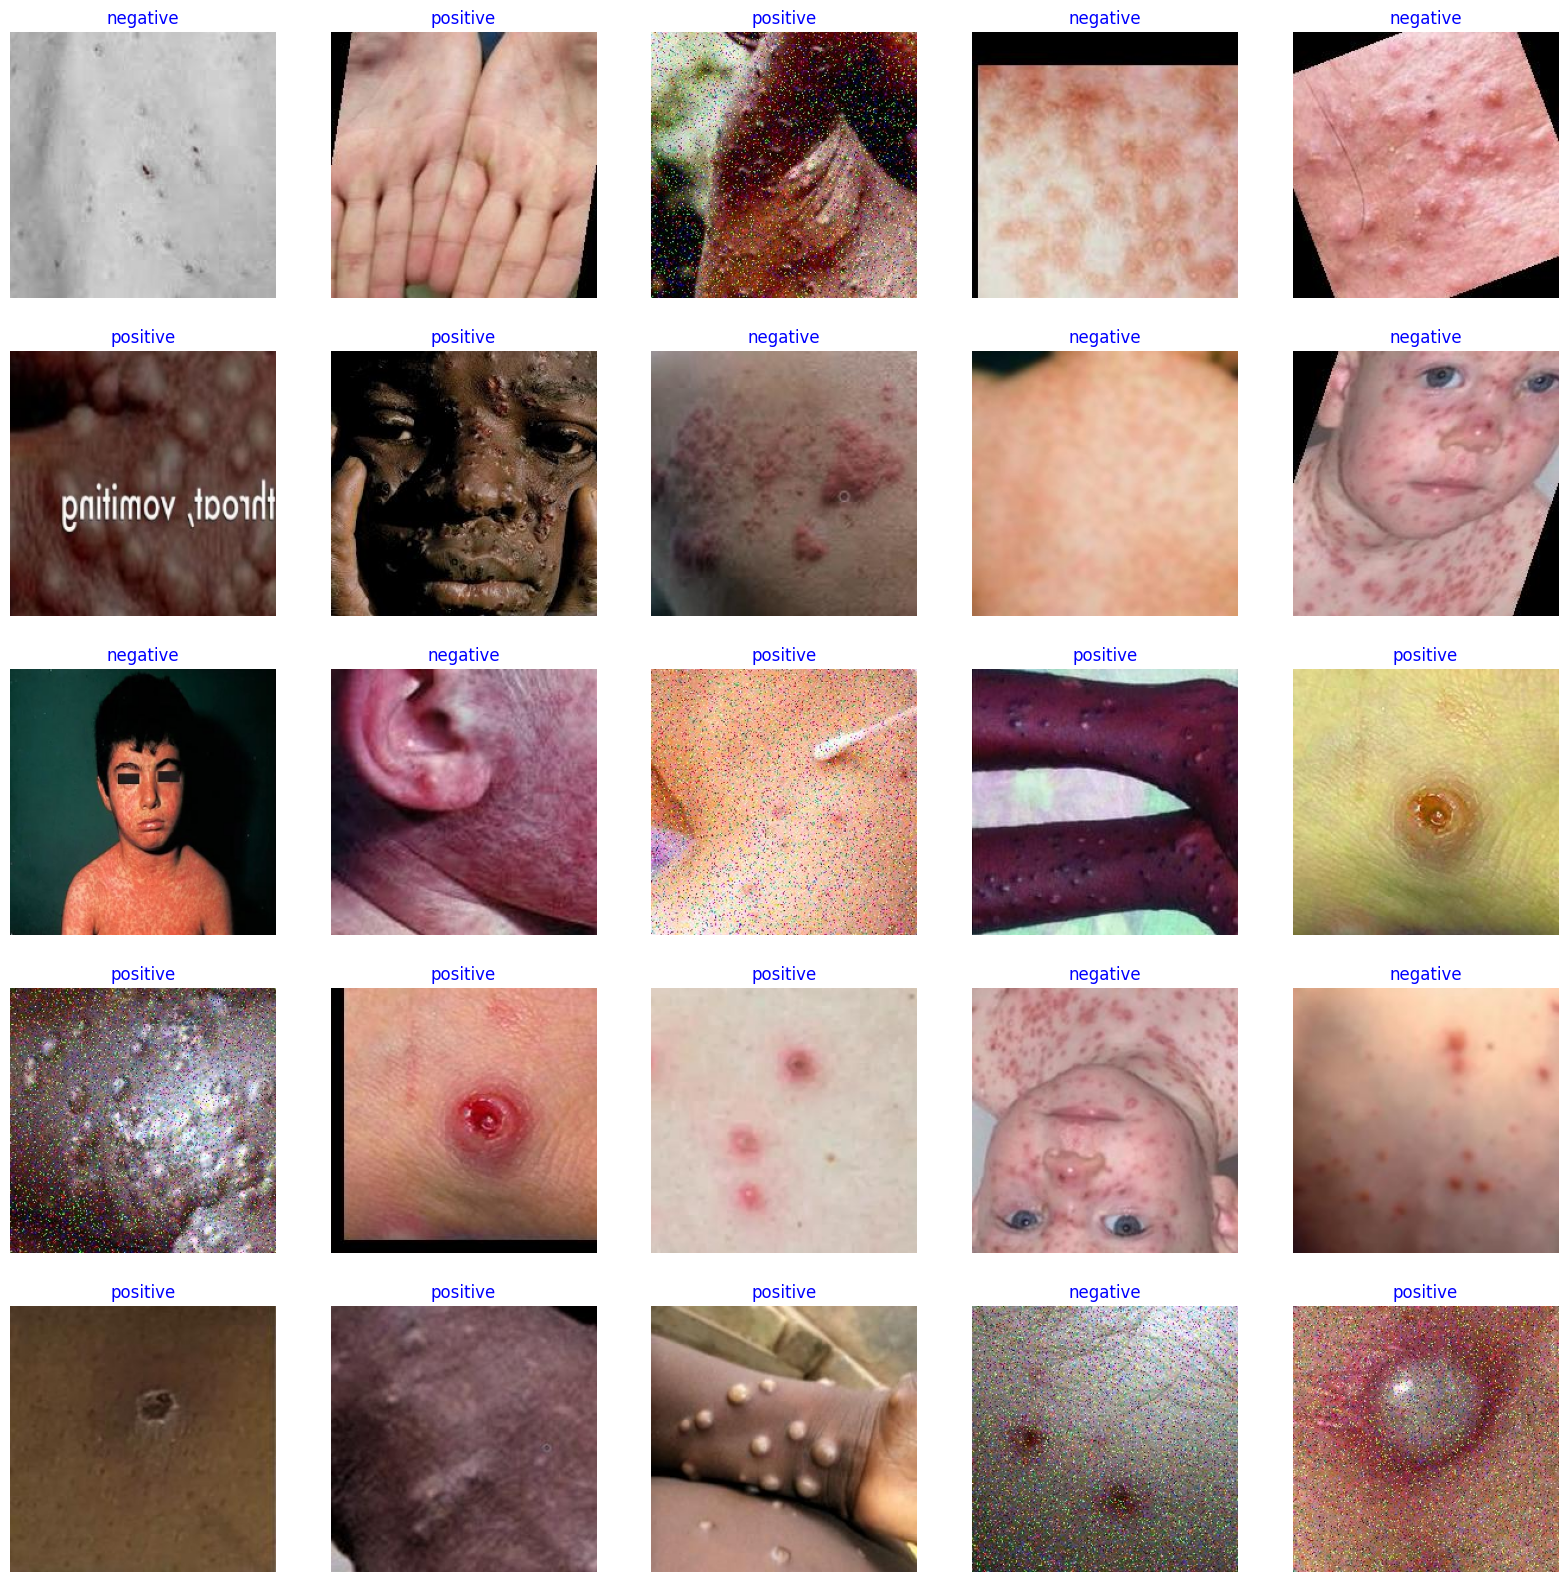

In [27]:
show_images(train_gen)

#### **Generic Model Creation**

In [28]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy','AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,183,665
Trainable params: 11,093,290
Non-trainable params: 90,375
_____________________________________

#### **Set Callback Parameters**

In [ ]:
# class F1ScoreCallback(tf.keras.callbacks.Callback):
#     def __init__(self, valid_gen):
#         self.validation_generator = valid_gen

#     def on_epoch_end(self, epoch, logs=None):
#         y_val = self.validation_generator.labels
#         y_pred = self.model.predict(self.validation_generator)
#         y_pred = np.argmax(y_pred, axis=1)
#         f1 = f1_score(y_val, y_pred, average='weighted')
#         print(f'F1-score: {f1:.4f}')

In [29]:
batch_size = 40   # set batch size for training
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3  # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/monkeypox_best_epoch", save_best_only=True)
callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch ), checkpoint_cb]

#### **Train model**

In [30]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
n
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     7.216   76.493   5.97393  52.421   0.00100  0.00100  accuracy     0.00    81.39  


 2 /40     5.131   89.979   5.10523  52.421   0.00100  0.00100  accuracy    17.63    45.01  


 3 /40     3.966   94.489   5.13680  52.755   0.00100  0.00050  val_loss    -0.62    44.75  
 4 /40     3.308   97.119   4.49507  52.922   0.00050  0.00050  val_loss    11.95    45.68  


 5 /40     2.985   97.912   3.65286  58.264   0.00050  0.00050  val_loss    18.74    45.46  


 6 /40     2.693   98.121   3.19967  64.775   0.00050  0.00050  val_loss    12.41    44.77  


 7 /40     2.430   98.789   2.87950  70.451   0.00050  0.00050  val_loss    10.01    45.10  


 8 /40     2.195   98.706   2.54285  76.294   0.00050  0.00050  val_loss    11.69    45.00  


 9 /40     1.984   98.831   2.10722  87.312   0.00050  0.00050  val_loss    17.13    45.47  


10 /40     1.795   98.831   1.87551  90.150   0.00050  0.00050  val_loss    11.00    44.38  


11 /40     1.617   99.081   1.70535  89.816   0.00050  0.00050  val_loss     9.07    44.79  


12 /40     1.449   99.123   1.47397  94.324   0.00050  0.00050  val_loss    13.57    44.47  


13 /40     1.305   99.040   1.51926  85.977   0.00050  0.00025  val_loss    -3.07    44.58  
14 /40     1.194   99.457   1.24241  95.492   0.00025  0.00025  val_loss    15.71    45.42  


15 /40     1.129   99.457   1.13628  96.494   0.00025  0.00025  val_loss     8.54    44.84  


16 /40     1.059   99.666   1.07085  96.661   0.00025  0.00025  val_loss     5.76    45.30  


17 /40     0.998   99.624   1.02438  95.993   0.00025  0.00025  val_loss     4.34    45.28  


18 /40     0.936   99.541   0.94051  96.828   0.00025  0.00025  val_loss     8.19    44.86  


19 /40     0.874   99.666   0.88020  97.663   0.00025  0.00025  val_loss     6.41    45.25  


20 /40     0.816   99.708   0.82296  97.496   0.00025  0.00025  val_loss     6.50    44.80  


21 /40     0.760   99.582   0.81308  95.326   0.00025  0.00025  val_loss     1.20    44.77  


22 /40     0.707   99.708   0.77246  94.992   0.00025  0.00025  val_loss     5.00    45.40  


23 /40     0.650   99.958   0.71260  95.826   0.00025  0.00025  val_loss     7.75    45.49  


24 /40     0.611   99.457   0.64043  96.494   0.00025  0.00025  val_loss    10.13    45.54  


25 /40     0.560   99.875   0.58182  97.162   0.00025  0.00025  val_loss     9.15    45.30  


26 /40     0.518   99.708   0.54190  96.828   0.00025  0.00025  val_loss     6.86    45.38  


27 /40     0.475   99.833   0.48838  97.663   0.00025  0.00025  val_loss     9.87    45.57  


28 /40     0.438   99.666   0.46602  96.995   0.00025  0.00025  val_loss     4.58    45.04  


29 /40     0.403   99.749   0.55330  92.821   0.00025  0.00013  val_loss    -18.73   44.88  
30 /40     0.376   99.833   0.44195  96.327   0.00013  0.00013  val_loss     5.17    45.41  


31 /40     0.357   99.958   0.40398  96.995   0.00013  0.00013  val_loss     8.59    44.99  


32 /40     0.344   99.791   0.38230  96.995   0.00013  0.00013  val_loss     5.37    46.00  


33 /40     0.330   99.875   0.35760  97.496   0.00013  0.00013  val_loss     6.46    45.13  


34 /40     0.314   99.875   0.34326  97.162   0.00013  0.00013  val_loss     4.01    45.72  


35 /40     0.306   99.666   0.34991  96.661   0.00013  0.00006  val_loss    -1.94    45.17  
36 /40     0.293   99.833   0.33659  96.494   0.00006  0.00006  val_loss     1.94    46.25  


37 /40     0.284   99.875   0.31910  96.828   0.00006  0.00006  val_loss     5.20    45.26  


38 /40     0.277   99.916   0.31902  97.162   0.00006  0.00006  val_loss     0.02    44.96  


39 /40     0.274   99.833   0.30755  97.329   0.00006  0.00006  val_loss     3.59    44.92  


40 /40     0.264   99.958   0.30155  97.162   0.00006  0.00006  val_loss     1.95    45.65  


training elapsed time was 1.0 hours, 23.0 minutes, 49.66 seconds)


#### **Display model performance**

In [31]:
trained_model = tf.keras.models.load_model('drive/MyDrive/monkeypox_best_epoch')

In [32]:
# Make predictions on the validation data
y_pred = trained_model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)


1/1 [==============================] - 7s 7s/step


In [33]:
from sklearn.metrics import f1_score
# Calculate the F1 score
f1 = f1_score(test_gen.labels, y_pred, average='weighted')

print(f'F1-score: {f1:.2f}')

F1-score: 0.93


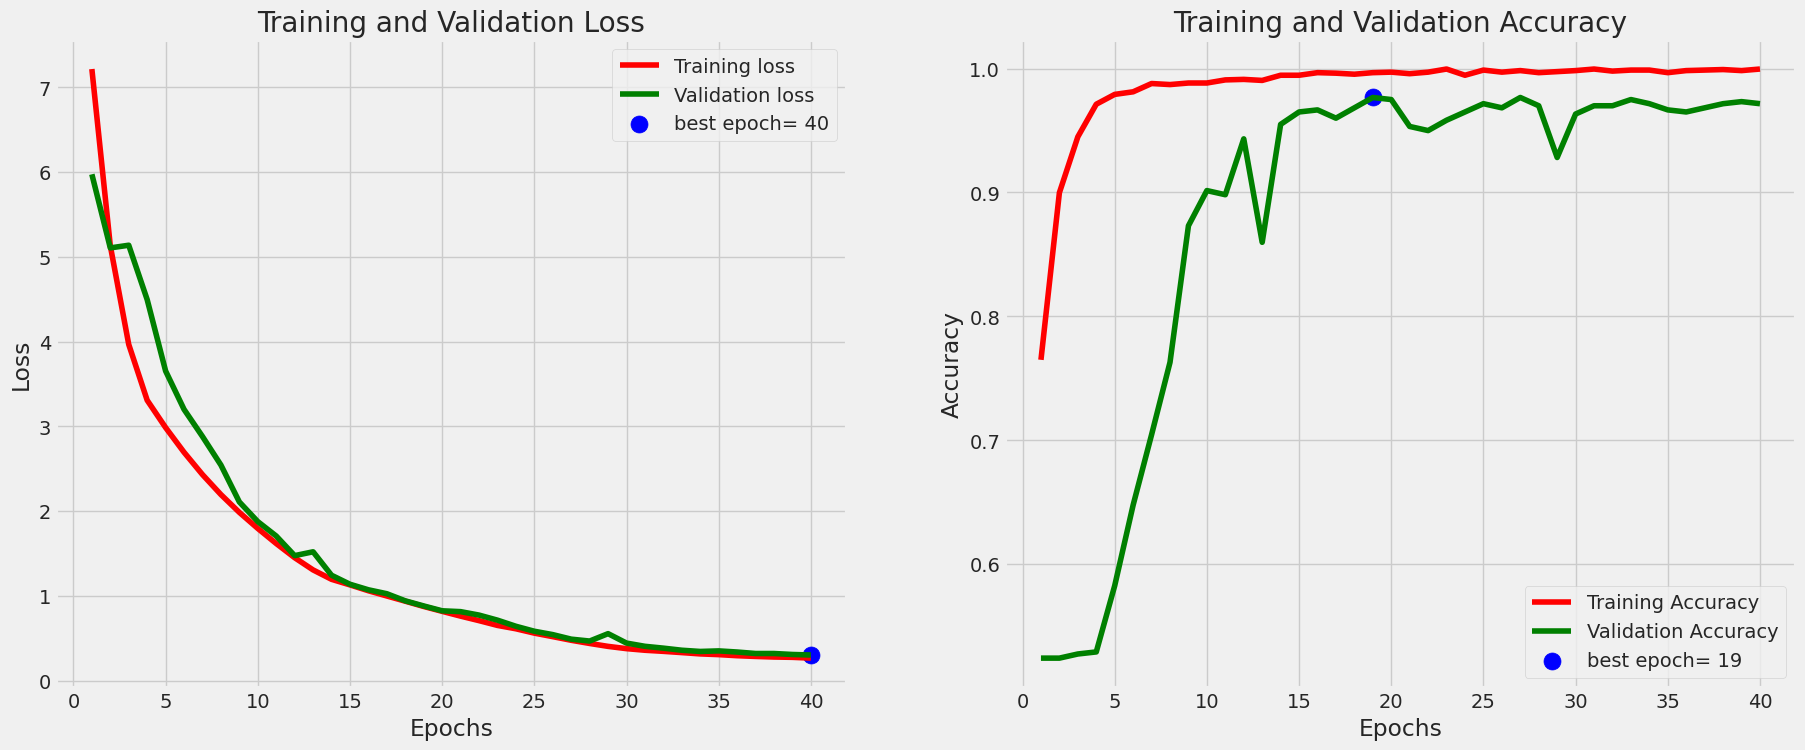

In [36]:
plot_training(history)

# **Evaluate model**

In [37]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = trained_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = trained_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = trained_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 1s 543ms/step - loss: 0.3917 - accuracy: 0.9265 - auc: 0.9833 - precision_1: 0.9265 - recall_1: 0.9265
Train Loss:  0.24567702412605286
Train Accuracy:  1.0
--------------------
Validation Loss:  0.35914891958236694
Validation Accuracy:  0.925000011920929
--------------------
Test Loss:  0.39174264669418335
Test Accuracy:  0.9264705777168274


# **Get Predictions**

In [38]:
preds = trained_model.predict_generator(test_gen)
print(preds)
y_pred = np.argmax(preds, axis=1)

[[0.89699244 0.10300751]
 [0.9774269  0.0225731 ]
 [0.82166386 0.17833616]
 [0.99217004 0.00782993]
 [0.9857304  0.01426966]
 [0.98745793 0.01254203]
 [0.4028087  0.59719133]
 [0.98316157 0.01683842]
 [0.95979804 0.04020192]
 [0.9810043  0.01899567]
 [0.9835783  0.0164217 ]
 [0.9906288  0.00937126]
 [0.9902942  0.0097058 ]
 [0.9851496  0.01485038]
 [0.72721964 0.27278036]
 [0.90876824 0.09123177]
 [0.49058348 0.5094165 ]
 [0.9897035  0.01029648]
 [0.95751053 0.04248952]
 [0.9788048  0.02119513]
 [0.97823596 0.0217641 ]
 [0.97005713 0.02994287]
 [0.9918662  0.00813383]
 [0.99007905 0.00992092]
 [0.98876613 0.0112338 ]
 [0.9721577  0.02784229]
 [0.98986346 0.01013654]
 [0.1023206  0.8976793 ]
 [0.9857547  0.01424534]
 [0.3181733  0.6818267 ]
 [0.8829252  0.11707482]
 [0.9891238  0.01087611]
 [0.9149762  0.08502383]
 [0.98783594 0.01216403]
 [0.8474338  0.1525662 ]
 [0.983071   0.01692902]
 [0.72201014 0.27798992]
 [0.9911554  0.00884455]
 [0.9815081  0.01849186]
 [0.7396346  0.2603654 ]


#### **Confusion Matrics and Classification Report**

Confusion Matrix, Without Normalization
[[43  5]
 [ 0 20]]
              precision    recall  f1-score   support

    negative       1.00      0.90      0.95        48
    positive       0.80      1.00      0.89        20

    accuracy                           0.93        68
   macro avg       0.90      0.95      0.92        68
weighted avg       0.94      0.93      0.93        68



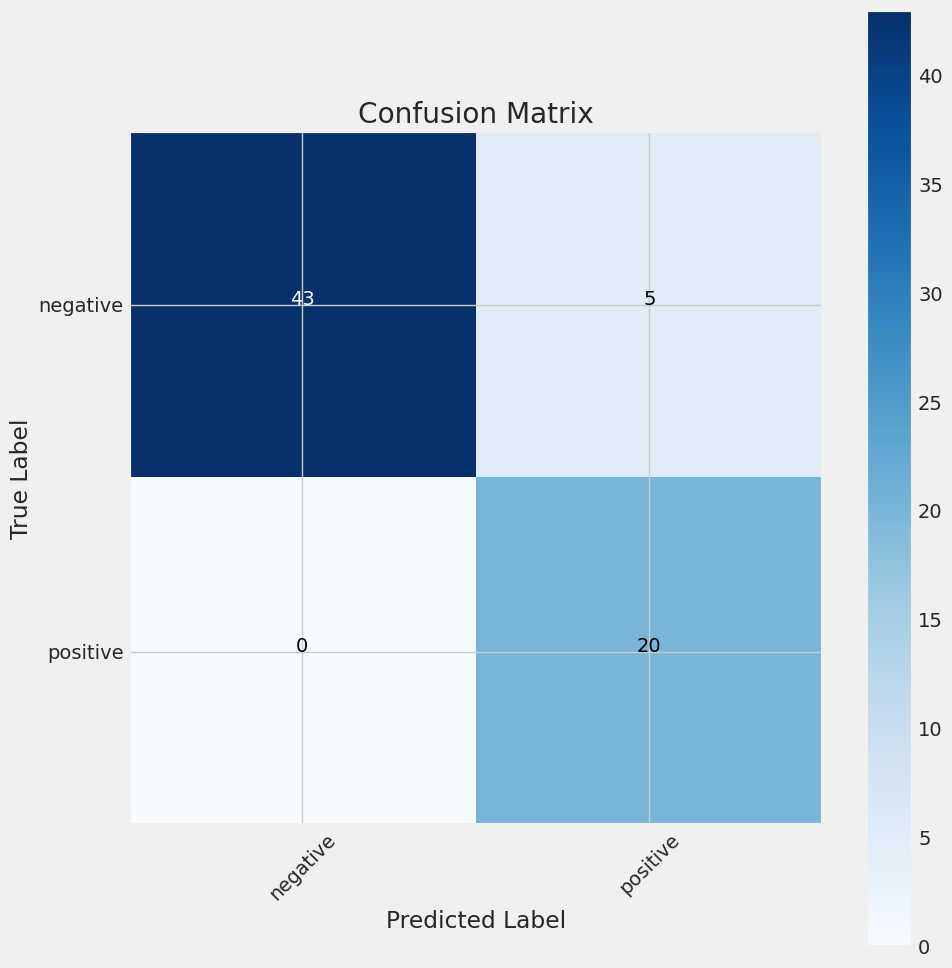

In [39]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [40]:
import json

file_path = 'drive/MyDrive/monkeypox_history.json'
# Save the history data to a file
with open(file_path, 'w') as f:
    json.dump(history.history, f)

drive/MyDrive/dataset/test/positive/M43_03.jpg
1/1 [==============================] - 0s 179ms/step
[0.02950105 0.970499  ]
drive/MyDrive/dataset/test/positive/M48_03.jpg
1/1 [==============================] - 0s 143ms/step
[0.06983138 0.9301687 ]
drive/MyDrive/dataset/test/negative/chickenpox104.png
1/1 [==============================] - 0s 141ms/step
[0.9915937  0.00840629]
drive/MyDrive/dataset/test/negative/NM67_01.jpg
1/1 [==============================] - 0s 123ms/step
[0.9589463  0.04105373]
drive/MyDrive/dataset/test/negative/measles80.png
1/1 [==============================] - 0s 130ms/step
[0.9897181  0.01028187]
drive/MyDrive/dataset/test/negative/NM31_01.jpg
1/1 [==============================] - 0s 156ms/step
[0.9912196  0.00878047]
drive/MyDrive/dataset/test/negative/chickenpox100.png
1/1 [==============================] - 0s 159ms/step
[0.8293808  0.17061922]
drive/MyDrive/dataset/test/positive/M19_02.jpg
1/1 [==============================] - 0s 86ms/step
[0.05376621 0.

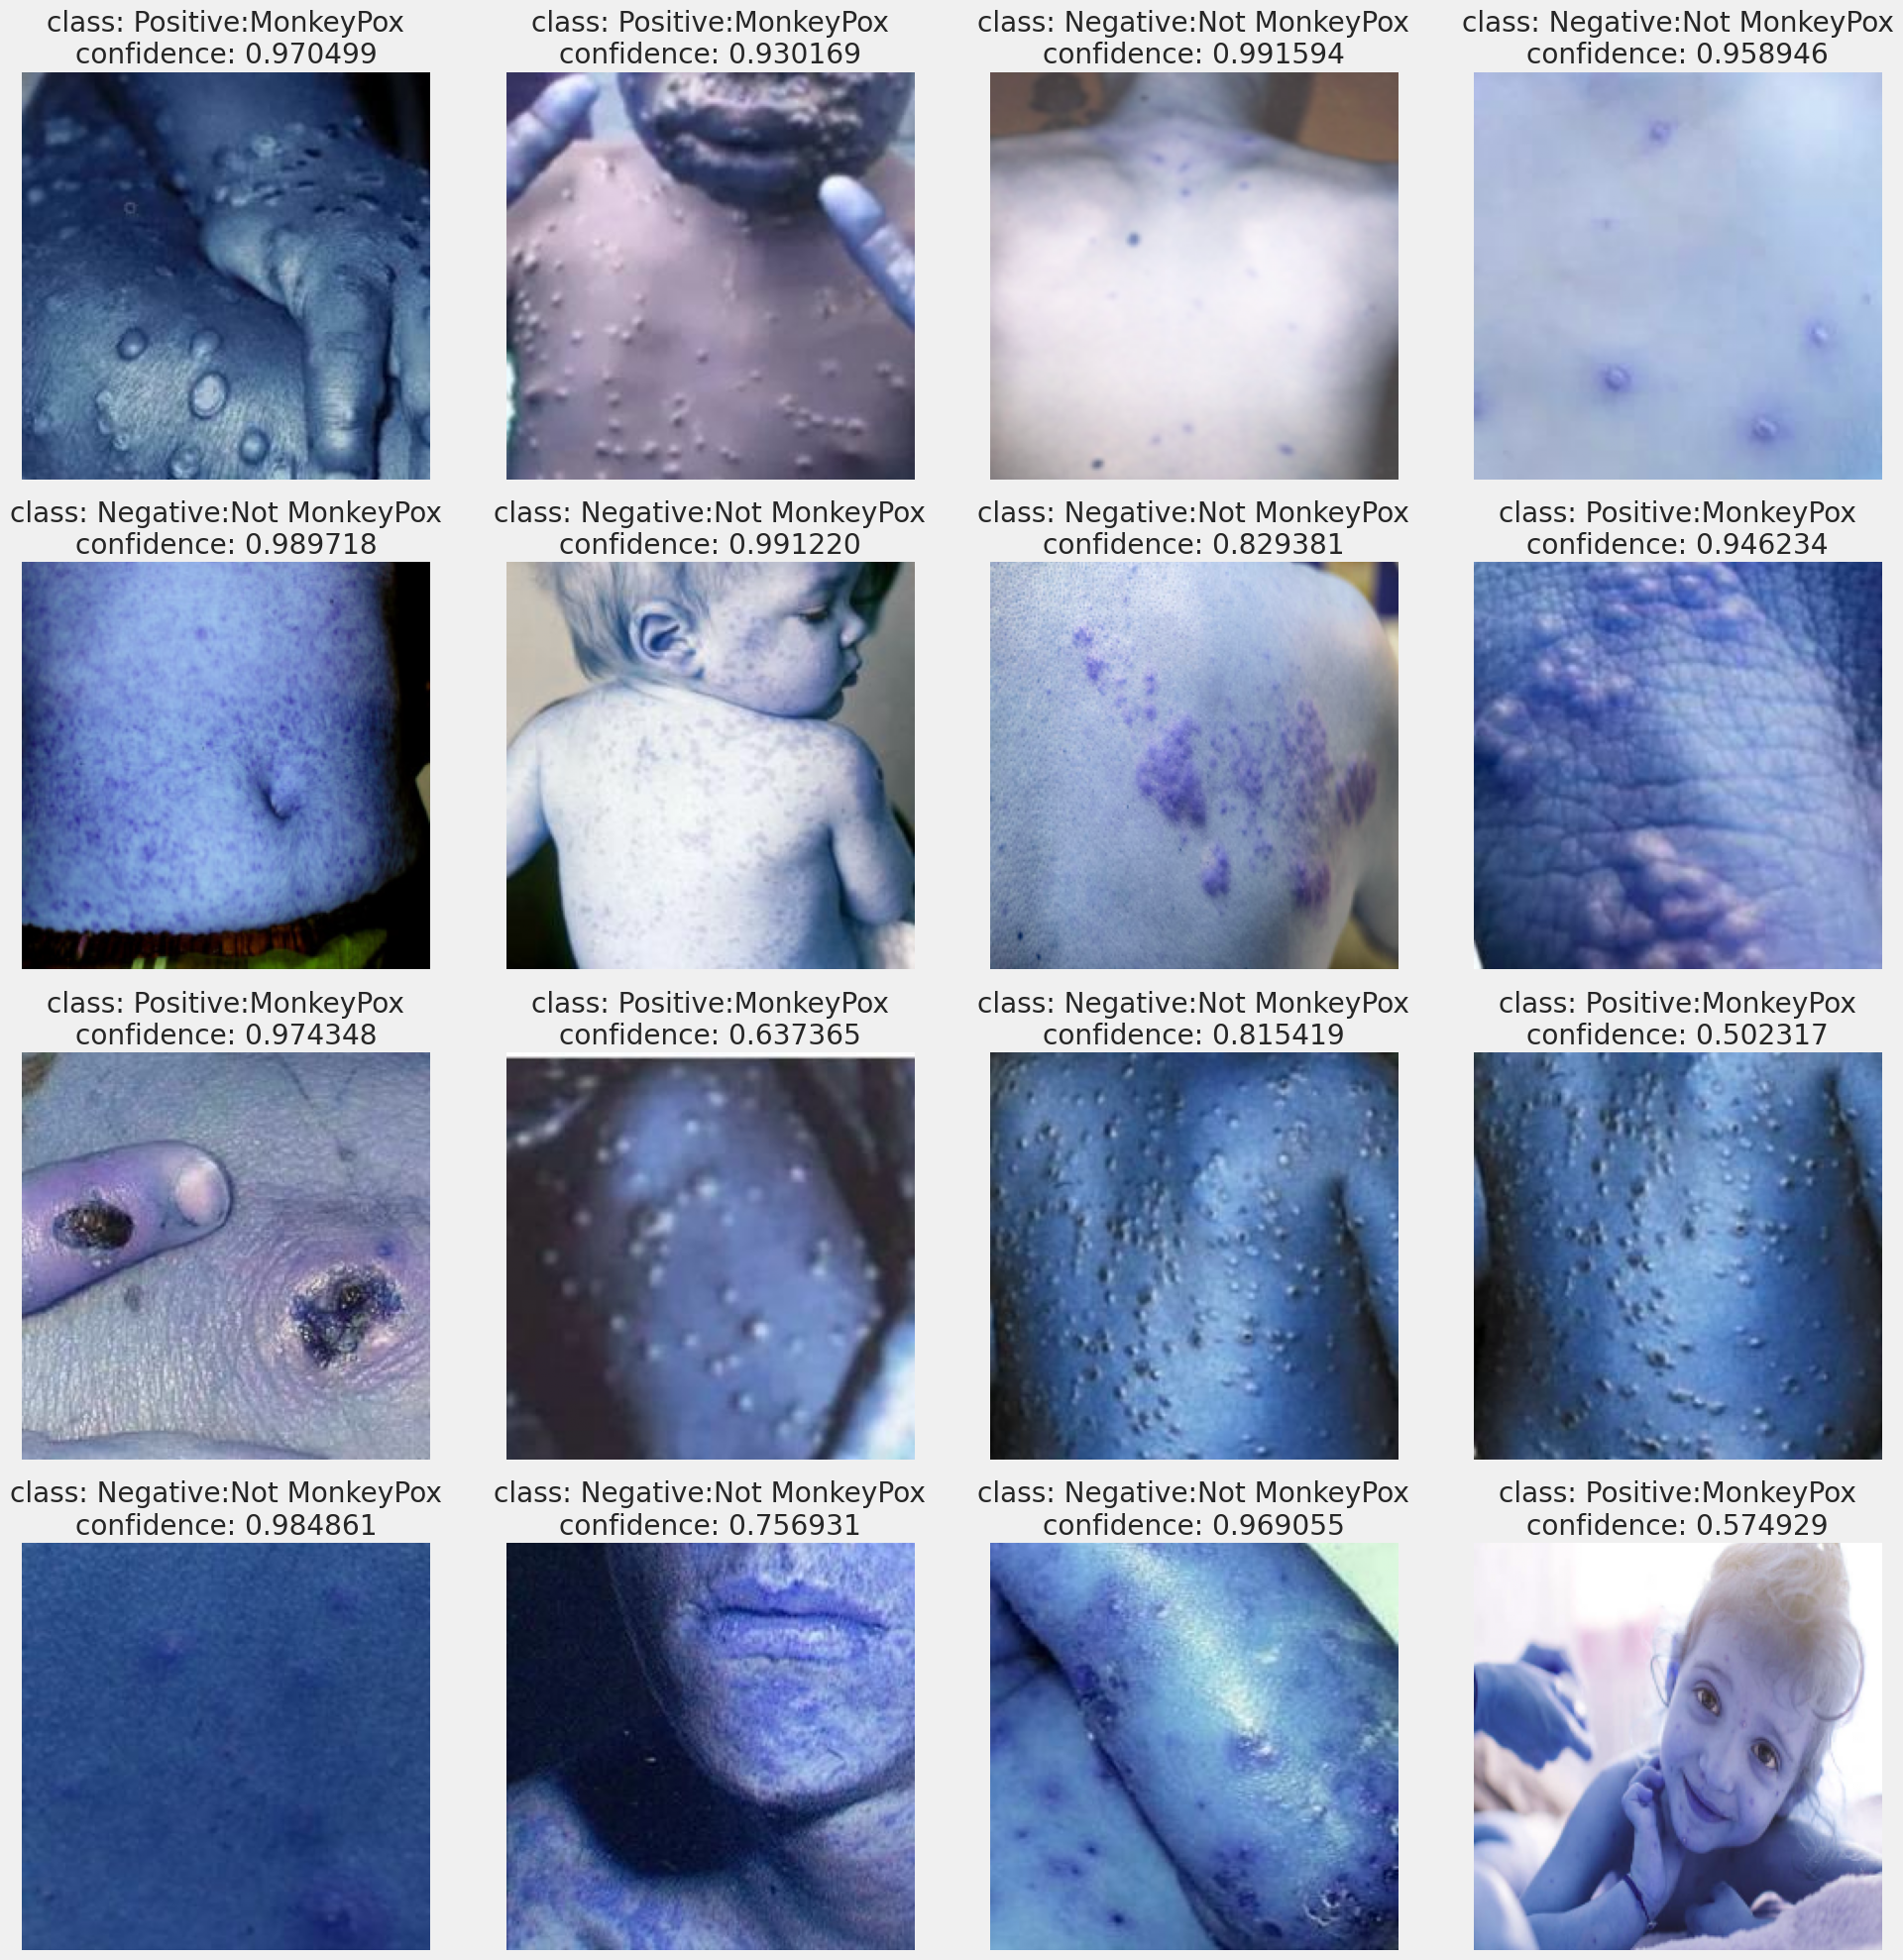

In [42]:
import random
Labels = ["Negative:Not MonkeyPox", "Positive:MonkeyPox"]

def upload(filename):
    print(filename)
    img = cv2.imread(os.path.join(filename))
    img = cv2.resize(img, (224, 224))
    img = img/255
    return img

def pre_result(img):
    x = trained_model.predict(np.asarray([img]))[0]
    print(x)
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}

images = random.sample(test_gen.filenames, 16)

fig = plt.figure(figsize=(20,20))

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)


    # Add the image to the grid
    ax = fig.add_subplot(4, 4, idx+1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("class: %s\nconfidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))

plt.tight_layout()
plt.show()


In [44]:
hist_df = pd.DataFrame(history.history)
hist_df.head(40)

loss  accuracy       auc  precision_1  recall_1  val_loss  \
0   7.215911  0.764927  0.845698     0.764927  0.764927  5.973933   
1   5.130878  0.899791  0.961711     0.899791  0.899791  5.105229   
2   3.965943  0.944885  0.984642     0.944885  0.944885  5.136797   
3   3.307521  0.971190  0.996161     0.971190  0.971190  4.495068   
4   2.985069  0.979123  0.996367     0.979123  0.979123  3.652856   
5   2.693319  0.981211  0.996953     0.981211  0.981211  3.199666   
6   2.430199  0.987891  0.997669     0.987891  0.987891  2.879503   
7   2.194563  0.987056  0.998679     0.987056  0.987056  2.542845   
8   1.984209  0.988309  0.999501     0.988309  0.988309  2.107219   
9   1.794698  0.988309  0.999103     0.988309  0.988309  1.875508   
10  1.616599  0.990814  0.999342     0.990814  0.990814  1.705351   
11  1.449442  0.991232  0.999612     0.991232  0.991232  1.473973   
12  1.305158  0.990397  0.999452     0.990397  0.990397  1.519258   
13  1.194386  0.994572  0.999749     0.994572  0.994572  1.242410   
14  1.128623  0.994572  0.999878     0.994572  0.994572  1.136284   
15  1.059402  0.996660  0.999954     0.996660  0.996660  1.070848   
16  0.997749  0.996242  0.999737     0.996242  0.996242  1.024377   
17  0.936277  0.995407  0.999711     0.995407  0.995407  0.940509   
18  0.873986  0.996660  0.999851     0.996660  0.996660  0.880203   
19  0.816459  0.997077  0.999590     0.997077  0.997077  0.822955   
20  0.760049  0.995825  0.999738     0.995825  0.995825  0.813080   
21  0.706827  0.997077  0.999959     0.997077  0.997077  0.772461   
22  0.650468  0.999582  1.000000     0.999582  0.999582  0.712602   
23  0.610722  0.994572  0.999752     0.994572  0.994572  0.640431   
24  0.559585  0.998747  0.999959     0.998747  0.998747  0.581822   
25  0.517873  0.997077  0.999747     0.997077  0.997077  0.541895   
26  0.474977  0.998330  0.999991     0.998330  0.998330  0.488384   
27  0.437569  0.996660  0.999981     0.996660  0.996660  0.466021   
28  0.403105  0.997495  0.999971     0.997495  0.997495  0.553296   
29  0.376346  0.998330  0.999969     0.998330  0.998330  0.441949   
30  0.357357  0.999582  0.999963     0.999582  0.999582  0.403978   
31  0.344416  0.997912  0.999915     0.997912  0.997912  0.382296   
32  0.329730  0.998747  0.999976     0.998747  0.998747  0.357597   
33  0.314248  0.998747  0.999989     0.998747  0.998747  0.343258   
34  0.305764  0.996660  0.999910     0.996660  0.996660  0.349906   
35  0.293023  0.998330  0.999727     0.998330  0.998330  0.336594   
36  0.284441  0.998747  0.999995     0.998747  0.998747  0.319096   
37  0.277383  0.999165  0.999999     0.999165  0.999165  0.319018   
38  0.273752  0.998330  0.999936     0.998330  0.998330  0.307551   
39  0.264464  0.999582  0.999991     0.999582  0.999582  0.301548   

    val_accuracy   val_auc  val_precision_1  val_recall_1  
0       0.524207  0.507504         0.524207      0.524207  
1       0.524207  0.523067         0.524207      0.524207  
2       0.527546  0.509851         0.527546      0.527546  
3       0.529215  0.542050         0.529215      0.529215  
4       0.582638  0.631128         0.582638      0.582638  
5       0.647746  0.709247         0.647746      0.647746  
6       0.704508  0.785575         0.704508      0.704508  
7       0.762938  0.829074         0.762938      0.762938  
8       0.873122  0.941914         0.873122      0.873122  
9       0.901502  0.954100         0.901502      0.901502  
10      0.898164  0.958453         0.898164      0.898164  
11      0.943239  0.981090         0.943239      0.943239  
12      0.859766  0.918548         0.859766      0.859766  
13      0.954925  0.986042         0.954925      0.954925  
14      0.964942  0.995153         0.964942      0.964942  
15      0.966611  0.995460         0.966611      0.966611  
16      0.959933  0.991881         0.959933      0.959933  
17      0.968280  0.996173         0.968280      0.968280  
18      0.976628  0.995867         0.9

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['loss'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['auc'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['precision_1'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['loss'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_6, *['auc'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['precision_1'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_8, *[[['loss', 'accuracy'], ['accuracy', 'auc'], ['auc', 'precision_1'], ['precision_1', 'recall_1']]], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_9, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_10, *['loss'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_11, *['accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_12, *['auc'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_13, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_14, *['loss'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_15, *['accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_16, *['auc'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_17, *[[['index', 'loss'], ['loss', 'accuracy'], ['accuracy', 'auc'], ['auc', 'precision_1']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_18, *['index', 'loss', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_19, *['index', 'accuracy', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_20, *['index', 'auc', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_21, *['index', 'precision_1', None], **{})
chart

In [45]:
test_gen.reset()  # resetting generator
y_pred = trained_model.predict(test_gen, verbose=1)

1/1 [==============================] - 0s 337ms/step


ROC AUC: 1.00



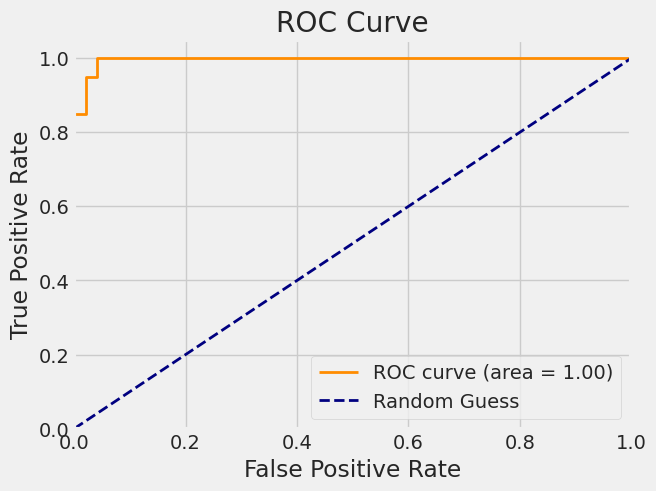

In [46]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = 2
for i in range(num_classes):
    y_pred_class_i = y_pred[:, i]
    fpr[i], tpr[i], _ = roc_curve(test_gen.labels, y_pred_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])


# print score
print('ROC AUC: %0.2f\n' % roc_auc[1])
plt.figure()
lw = 2  # Line width

plt.plot(fpr[1], tpr[1], color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, label='Random Guess', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [47]:
# Generate predictions for validation dataset
y_pred = trained_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

1/1 [==============================] - 0s 392ms/step


[[0.89583333 0.10416667]
 [0.         1.        ]]


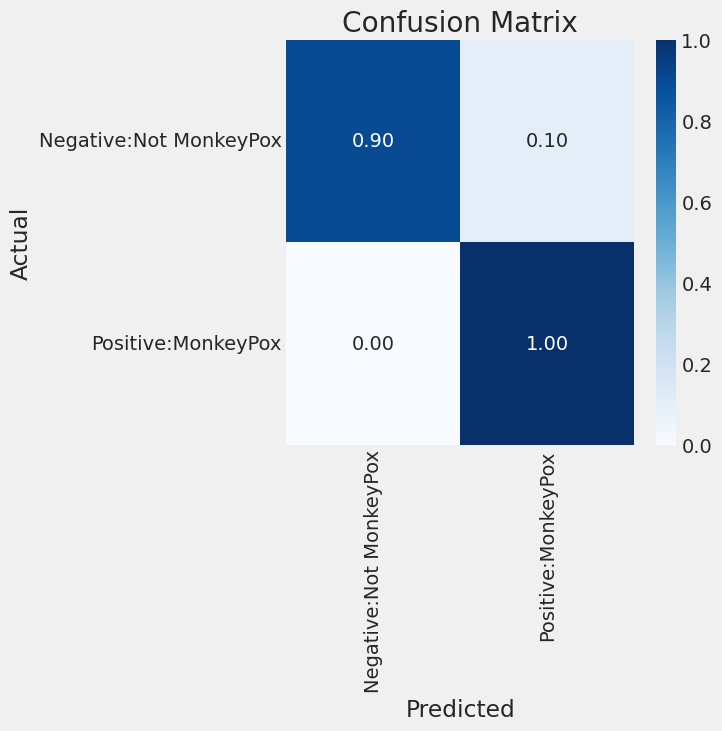

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


# Create confusion matrix
cmn = confusion_matrix(test_gen.classes, y_pred_classes)
cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
print(cmn)
# Plot confusion matrix
plt.figure(figsize=(5, 5))
sn.heatmap(cmn, annot=True, cmap='Blues', fmt='.2f', xticklabels=Labels, yticklabels=Labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()